In [1]:
using Pkg
venv_dir = (@__DIR__) * "/../muc_venv/"
Pkg.activate(venv_dir)

using Revise
import PhysicalConstants.CODATA2018: G
using NaturallyUnitful
using DifferentialEquations
using Roots
using QuadGK
using Interpolations
using PythonPlot
using LaTeXStrings
import SpecialFunctions: besselk
import DelimitedFiles: writedlm, readdlm

figdir = "./"

golden_ratio = (1+sqrt(5))/2

const lifetime_conv = ustrip(unnatural(u"s", 1*u"GeV^-1"))

rc("font", family="serif", serif="Computer Modern", size=14)
rc("figure", autolayout=true)
rc("axes", labelsize=16, unicode_minus=false)
rc("text", usetex=true)
rc("text.latex", preamble=raw"\usepackage{slashed}")
;

  Activating project at `~/Dropbox (University of Oregon)/research/flavorDM2/Aria/muc_venv`


In [2]:
includet(venv_dir*"boltz_utils.jl")
using .utils

includet(venv_dir*"gstar.jl")
using .gstar

In [3]:
includet((@__DIR__)*"/cross_sections.jl")
using .LLFDM

In [4]:
function Γ_φm_tot(model::LFDM)
    Γ_φm_to_φ0eν(model) + 3*Γ_φ_to_χl(model) + Γ_φm_to_φ0μν(model)
end

function Γ_φ0_tot(model::LFDM)
    3*Γ_φ_to_χl(model)
end

Γ_φ0_tot (generic function with 1 method)

In [5]:
function Γ_φu_to_φdeν(dm)
    LLFDM.αEM^2*dm^5 / (30*π*LLFDM.sw^4*LLFDM.mW^4)
end

function Γ_φu_to_φdμν(msca, dm)
    me = LLFDM.mμ/msca
    y = dm/msca
    sw = LLFDM.sw
    αEM = LLFDM.αEM
    mW = LLFDM.mW
    function f(u)
        (αEM^2*((msca^4*(-1 + u)*y*(-2 + y + u*y)*
              sqrt(me^4 + u^2*y^2*(-2 + u*y)^2 - 2*me^2*(2 - 2*u*y + u^2*y^2))*
              (-(mW^2*(me^2 - 4*(-1 + u*y)^2)) + 
                msca^2*(me^4 - 4*me^2*(-1 + u*y)^2 + 
                   4*(-1 + u)*u*y^2*(4 - 2*(1 + 2*u)*y + u*(1 + u)*y^2))))/
            (-(mW^4*(-1 + u*y)^2) - me^2*msca^4*
               (me^2*(-1 + y)^2 - (-1 + u)*(-2 + y)*y^2*(-2 + y + u*y)) + 
              msca^2*mW^2*(-((-1 + u)*u*y^2*(4 - 2*(1 + 2*u)*y + u*(1 + u)*y^2)) + 
                 me^2*(2 - 2*(1 + u)*y + (1 + u^2)*y^2))) - 
           (-(me^2*msca^2) + 4*(msca - msca*u*y)^2)*
            log((-4*mW^2*(msca - msca*u*y)^2 + msca^4*(me^2 + (-2 + y)*y)^2 - 
                msca^4*(2*(-1 + u)*y - (-1 + u^2)*y^2 + 
                    sqrt(me^4 + u^2*y^2*(-2 + u*y)^2 - 2*me^2*(2 - 2*u*y + u^2*y^2)))^2)/
              (-4*mW^2*(msca - msca*u*y)^2 + msca^4*(me^2 + (-2 + y)*y)^2 - 
                msca^4*(-2*(-1 + u)*y + (-1 + u^2)*y^2 + 
                    sqrt(me^4 + u^2*y^2*(-2 + u*y)^2 - 2*me^2*(2 - 2*u*y + u^2*y^2)))^2))))/
        (64.0*msca^3*π*sw^4)
    end
    return 2*msca^2*y*quadgk(f,me/y,1,rtol=1e-6)[1]
end

Γ_φu_to_φdμν (generic function with 1 method)

In [6]:
println(Γ_φu_to_φdeν(.111))
println(Γ_φu_to_φdμν(1e6, .111))

4.268598671886287e-18
6.397758862314906e-22


### Cross-sections and diffeqs

In [5]:
function pi2σ_φpφm_to_f(α, model::LFDM)
    pi2σ_φpφm_to_γγ(α, model) + 2*pi2σ_φpφm_to_γZ(α, model) + 
    3*pi2σ_φpφm_to_ll(α, model) + pi2σ_φpφm_to_ZZ(α, model) +
    pi2σ_φpφm_to_WW(α, model)
end

function pi2σ_φmφ0_to_f(α, model::LFDM)
    2*pi2σ_φmφ0_to_WmZ(α, model) + 2*pi2σ_φmφ0_to_Wmγ(α, model) +
    3*pi2σ_φmφ0_to_lvl(α, model)
end

function pi2σ_φ0φ0_to_f(α, model::LFDM)
    pi2σ_φ0φ0_to_ZZ(α, model) + 3*pi2σ_φ0φ0_to_ll(α, model) +
    pi2σ_φ0φ0_to_WW(α, model)
end

function lifetime_φm(λ, mφ, mχ)
    mm = LFDM(λ, mφ, mχ)
    decay = 3*Γ_φ_to_χl(mm) + Γ_φm_to_φ0eν(mm) + Γ_φm_to_φ0μν(mm)
    return lifetime_conv/decay
end

function lifetime_φ0(λ, mφ, mχ)
    mm = LFDM(λ, mφ, mχ)
    decay = 3*Γ_φ_to_χl(mm)
    return lifetime_conv/decay
end
;

In [19]:
find_λ(1e3, 1e-5)

2.045676286985731e-8

In [17]:
mm = LFDM(find_λ(1e3, 1e-1), 1e3, 1e-1)
pi2σ_φpφm_to_ll((10)^2, mm)

6.297330701164332e-5

In [6]:
function diffeq(du, u, p, x)
    zeq = z_eq(x, p.gφ)
    zeqx = z_eq(x*p.mχ/p.mφ, p.gχ)

    zm, z0, Yx = u

    c12_χ = 3*C12(Γ_φ_to_χl, x, p.mφ; args=(p,))
    c12_φ0 = 3*C12(Γ_φm_to_φ0eν, x, p.mφ; args=(p,))
    c22_φm = C22(pi2σ_φpφm_to_f, x, p.mφ, p.gφ; args=(p,))
    c22_cross = C22(pi2σ_φmφ0_to_f, x, p.mφ, p.gφ; args=(p,))
    c22_φ0 = C22(pi2σ_φ0φ0_to_f, x, p.mφ, p.gφ; args=(p,))
    
    du[1] = c22_φm * (exp(-zm) - exp(zm - 2*zeq)) +
            c22_cross * (exp(-z0) - exp(zm - 2*zeq)) +
            c12_χ * (1 - Yx*exp(zm - zeq + zeqx)) +
            c12_φ0 * (1 - exp(zm-z0))

    du[2] = c22_φ0 * (exp(-z0) - exp(z0 - 2*zeq)) +
            c22_cross * (exp(-zm) - exp(z0 - 2*zeq)) +
            c12_χ * (1 - Yx*exp(z0 - zeq + zeqx)) +
            c12_φ0 * (1 - exp(z0-zm))
    
    du[3] = c12_χ * (exp(-zm) + exp(-z0) - 2*Yx*exp(-zeq+zeqx))
end

function diffeq_φ(du, u, p, x)
    zeq = z_eq(x, p.gφ)

    zm, z0 = u

    c12_φ0 = C12(Γ_φm_to_φ0eν, x, p.mφ; args=(p,))
    c22_φm = C22(pi2σ_φpφm_to_f, x, p.mφ, p.gφ; args=(p,))
    c22_cross = C22(pi2σ_φmφ0_to_f, x, p.mφ, p.gφ; args=(p,))
    c22_φ0 = C22(pi2σ_φ0φ0_to_f, x, p.mφ, p.gφ; args=(p,))

    du[1] = c22_φm * (exp(-zm) - exp(zm - 2*zeq)) +
            c22_cross * (exp(-z0) - exp(zm - 2*zeq)) +
            c12_φ0 * (1 - exp(zm-z0))

    du[2] = c22_φ0 * (exp(-z0) - exp(z0 - 2*zeq)) +
            c22_cross * (exp(-zm) - exp(z0 - 2*zeq)) +
            c12_φ0 * (1 - exp(z0-zm))
end
;

In [7]:
function solve_boltz(λ, mφ, mχ; xspan=(1e-4, 1e8))
    mm = LFDM(λ, mφ, mχ)

    # y0 = [Y_eq(xspan[1], mm.gφ), 0.0]
    z0 = [z_eq(xspan[1], mm.gφ), z_eq(xspan[1], mm.gφ), 0.0]

    prob = ODEProblem(diffeq, z0, xspan, mm)
    sol = solve(prob, Rodas4P(); reltol=1e-8, verbose=false)

    return sol
end

function find_yφfo(mφ; xspan=(1e-4, 1e8))
    mm = LFDM(0.0, mφ, 0.0)

    z0 = [z_eq(xspan[1], mm.gφ), z_eq(xspan[1], mm.gφ)]

    prob = ODEProblem(diffeq_φ, z0, xspan, mm)
    sol = solve(prob, Rodas4P(); reltol=1e-8, verbose=false)

    return exp.(-sol(xspan[2]))
end

function yχf_I(mφ)
    quadgk(x -> x^3*besselk(1,x)/sqrt(gstar_interp(mφ/x)), 0, Inf)[1]
end

"""
    find_yχf(λ, mφ, mχ; gφ=1)

Calculates the final χ yield, assuming φ remains in equilibrium
"""
function find_yχfi(λ, mφ, mχ; gφ=1)
    mm = LFDM(λ, mφ, gφ, mχ, 2)
    I = yχf_I(mφ)
    return I * gφ*6*Γ_φ_to_χl(mm) / (2*π^2*mφ^2*utils.h_consts)
end

"""
    find_yχf(I, λ, mφ, mχ; gφ=1)

When called with the result of the integral as the first argument, skips
re-calculating the integral (useful because the integral only depends on mφ)
"""
function find_yχfi(I, λ, mφ, mχ; gφ=1)
    mm = LFDM(λ, mφ, gφ, mχ, 2)

    return I * gφ*6*Γ_φ_to_χl(mm) / (2*π^2*mφ^2*utils.h_consts)
end

function find_yχf_full(λ, mφ, mχ; xspan=(1e-4, 1e8))
    mm = LFDM(λ, mφ, mχ)

    # y0 = [Y_eq(xspan[1], mm.gφ), 0.0]
    z0 = [z_eq(xspan[1], mm.gφ), z_eq(xspan[1], mm.gφ), 0.0]

    prob = ODEProblem(diffeq, z0, xspan, mm)
    sol = solve(prob, Rodas4P(); reltol=1e-8, verbose=false)

    return sol(xspan[2])[3]
end

function find_mχ_max()
    find_zero(x -> utils.Mstar_s(x/25) - x*sum(find_yφfo(x)), (1e3, 1e4))
end

function mχ_upper_bound(mφ; mχ_max=2016.2725711034257)
    if mφ > mχ_max
        return Mstar_s(mφ/25)/sum(find_yφfo(mφ))
    else
        return mφ
    end
end
;

In [14]:
mφ_for_bounds = 10 .^ range(log10(100), log10(10000/2), 100)
mχ_uppers = mχ_upper_bound.(mφ_for_bounds)

100-element Vector{Float64}:
  100.0
  104.03065027260045
  108.22376196140104
  112.5858833179166
  117.12382653077982
  121.84467836412279
  126.75581122475543
  131.86489467542296
  137.1799074121222
  142.70914972418177
    ⋮
 1133.5331633443545
 1090.937250942785
 1049.9568366559536
 1010.530816403395
  972.5990572639834
  936.1038710697311
  900.9907480368413
  867.2068341450001
  834.7008511642387

In [15]:
writedlm("mphi_for_mchi_bounds.csv", mφ_for_bounds)
writedlm("mchi_uppers.csv", mχ_uppers)

In [8]:
find_mχ_max()

2016.2725711034257

### Particular solution

In [11]:
λ = 1e-12
mφ = 1e3 # GeV
mχ = 1e-2 # GeV

sol = solve_boltz(λ, mφ, mχ);
yφfo = find_yφfo(mφ);
yχfi = find_yχfi(λ, mφ, mχ);

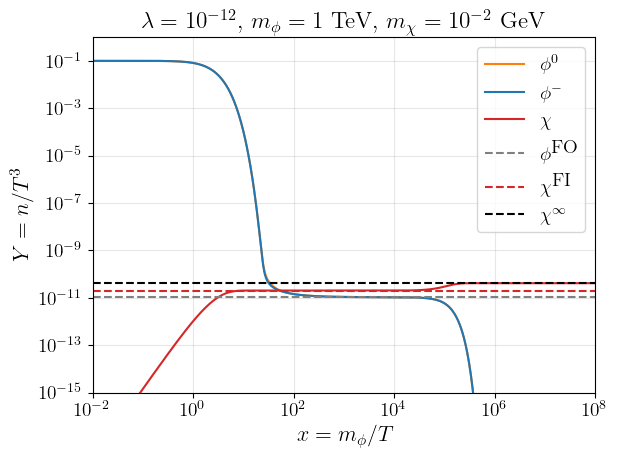

In [8]:
xs = 10 .^ range(-4, 8, 1000)
s = sol(xs)
Y_phim = exp.(-s[1,:])
Y_phi0 = exp.(-s[2,:])
Y_chi = s[3,:]

fig = figure()

plot(xs, Y_phi0, label=L"$\phi^0$", c="tab:orange")
plot(xs, Y_phim, label=L"$\phi^-$", c="tab:blue")
plot(xs, Y_chi, label=L"$\chi$", c="tab:red")

axhline(0.5*sum(yφfo), c="grey", ls="dashed", label=L"\phi^{\textrm{FO}}")
axhline(yχfi, c="tab:red", ls="dashed", label=L"\chi^{\textrm{FI}}")
axhline(yχfi+sum(yφfo), c="black", ls="dashed", label=L"\chi^{\infty}")

xlim(1e-2, 1e8)
ylim(1e-15, 1)

xscale("log")
yscale("log")

grid(alpha=0.3)

legend()

xlabel(L"x = m_\phi/T")
ylabel(L"Y = n/T^3")
title(L"$\lambda = 10^{-12}$, $m_\phi = 1$ TeV, $m_\chi = 10^{-2}$ GeV")

plotclose()
# fig.savefig("boltz_LL.pdf")
fig

### Coupling that gives correct relic abundance $\Omega h^2 \approx .12$

In [9]:
function find_λ(mφ, mχ, yφfo)
    yχfi = find_yχfi(1.0, mφ, mχ)
    return sqrt( (Mstar_s(mφ/25)/mχ - yφfo) / yχfi )
end

function find_λ(mφ, mχ)
    yφfo = sum(find_yφfo(mφ))
    return find_λ(mφ, mχ, yφfo)
end

function find_λs(Mφ, Mχ)
    result = zeros(Float64, (length(Mφ), length(Mχ)))
    Threads.@threads for i in eachindex(Mφ)
        yφfo = sum(find_yφfo(Mφ[i]))
        yχI = yχf_I(Mφ[i])

        for j in eachindex(Mχ)
            if (Mχ[j] < Mstar_s(Mφ[i]/25)/yφfo) & (Mχ[j] < Mφ[i])
                yχfi = find_yχfi(yχI, 1.0, Mφ[i], Mχ[j])
                result[i,j] = sqrt( (Mstar_s(Mφ[i]/25)/Mχ[j] - yφfo) / yχfi )
            else
                result[i,j] = NaN
            end
        end
    end
    return result
end
;

In [9]:
mm = LFDM(find_λ(2e3, 1e-5), 2e3, 1e-5)
display(3*Γ_φ_to_χl(mm))
display(Γ_φm_to_φ0eν(mm)+Γ_φm_to_φ0μν(mm))
display(Γ_φm_tot(mm))

9.99045370235027e-14

1.5382467841555736e-15

1.0144278380765827e-13

In [14]:
Γ_φm_tot(LFDM(find_λ(1e3, 1e-5), 1e3, 1e-4))

2.6379363913465166e-14

#### Plotting a particular "correct" $λ$

In [8]:
mφ = 1e2 # GeV
mχ = 1e-3 # GeV
λ = find_λ(mφ, mχ)

sol = solve_boltz(λ, mφ, mχ)
yφfo = find_yφfo(mφ)
yχfi = find_yχfi(λ, mφ, mχ)
;

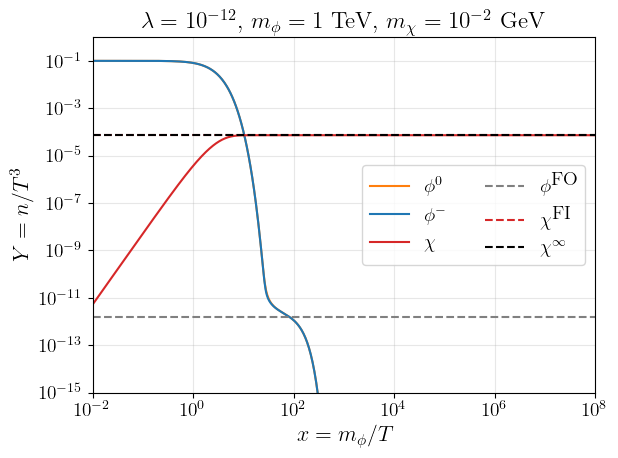

In [25]:
xs = 10 .^ range(-4, 8, 1000)
s = sol(xs)
Y_phim = exp.(-s[1,:])
Y_phi0 = exp.(-s[2,:])
Y_chi = s[3,:]

fig = figure()

plot(xs, Y_phi0, label=L"$\phi^0$", c="tab:orange")
plot(xs, Y_phim, label=L"$\phi^-$", c="tab:blue")
plot(xs, Y_chi, label=L"$\chi$", c="tab:red")

axhline(0.5*sum(yφfo), c="grey", ls="dashed", label=L"\phi^{\textrm{FO}}")
axhline(yχfi, c="tab:red", ls="dashed", label=L"\chi^{\textrm{FI}}")
axhline(yχfi+sum(yφfo), c="black", ls="dashed", label=L"\chi^{\infty}")

xlim(1e-2, 1e8)
ylim(1e-15, 1)

xscale("log")
yscale("log")

grid(alpha=0.3)

legend(ncol=2)

xlabel(L"x = m_\phi/T")
ylabel(L"Y = n/T^3")
title(L"$\lambda = 10^{-12}$, $m_\phi = 1$ TeV, $m_\chi = 10^{-2}$ GeV")

plotclose()
# fig.savefig("boltz_LL.pdf")
fig

#### Grid

In [ ]:
mphis = 10 .^ range(2, 5, 1000)
mchis = 10 .^ range(-5, 4, 1000)
# mphis = vcat(100.0:25.0:350.0, 400.0:50.0:800.0, 900.0:100.0:1600.0, 1800.0:200.0:5000.0)
# mchis = 10 .^ range(-5.0, 4.0, 100)
lambdas = find_λs(mphis, mchis)

1000×1000 Matrix{Float64}:
 5.98932e-9  5.92752e-9  5.86636e-9  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 6.01322e-9  5.95118e-9  5.88977e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 6.03724e-9  5.97494e-9  5.91329e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 6.06136e-9  5.99882e-9  5.93692e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 6.0856e-9   6.02281e-9  5.96066e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 6.10995e-9  6.04691e-9  5.98451e-9  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 6.13442e-9  6.07112e-9  6.00848e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 6.15901e-9  6.09545e-9  6.03256e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 6.1837e-9   6.1199e-9   6.05675e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 6.20852e-9  6.14446e-9  6.08106e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 ⋮                                   ⋱              ⋮                 
 1.98987e-7  1.96934e-7  1.94902e-7     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 1.99676e-7  1.97616e-7  1.95577e-7     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 2.00368e-7  1

In [11]:
writedlm("LL_lambdas_plot.csv", lambdas)
writedlm("mphis_plot.csv", mphis)
writedlm("mchis_plot.csv", mchis)

In [10]:
lambdas = readdlm("LL_lambdas_plot.csv")
mphis = readdlm("mphis_plot.csv")[:]
mchis = readdlm("mchis_plot.csv")[:]
;

In [19]:
writedlm("LL_lambdas_grid.csv", lambdas)
writedlm("mphis_grid.csv", mphis)
writedlm("mchis_grid.csv", mchis)

In [7]:
lambdas = readdlm("LL_lambdas_grid.csv")

45×100 Matrix{Float64}:
 5.98932e-9  5.39415e-9  4.85812e-9  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 6.82119e-9  6.14336e-9  5.53288e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 7.58858e-9  6.83448e-9  6.15533e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 8.28218e-9  7.45917e-9  6.71793e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 8.9137e-9   8.02793e-9  7.23018e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 9.49561e-9  8.55201e-9  7.70218e-9  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 1.0047e-8   9.04861e-9  8.14943e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 1.05658e-8  9.51589e-9  8.57028e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 1.1058e-8   9.9591e-9   8.96945e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 1.15301e-8  1.03844e-8  9.35245e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 ⋮                                   ⋱              ⋮                 
 3.77204e-8  3.39721e-8  3.05962e-8     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 3.8814e-8   3.4957e-8   3.14832e-8     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 3.98776e-8  3.59

In [10]:
models = LFDM.(lambdas, mphis, mchis')
# phim_totwidth = Γ_φm_tot.(models)

1000×1000 Matrix{LFDM{Float64}}:
 LFDM{Float64}(5.98932e-9, 100.0, 1.0, 1.0e-5, 2.0, 0.165719, 1.40342e-14)    …  LFDM{Float64}(NaN, 100.0, 1.0, 10000.0, 2.0, 0.165719, 1.40342e-14)
 LFDM{Float64}(6.01322e-9, 100.694, 1.0, 1.0e-5, 2.0, 0.167233, 1.42296e-14)     LFDM{Float64}(NaN, 100.694, 1.0, 10000.0, 2.0, 0.167233, 1.42296e-14)
 LFDM{Float64}(6.03724e-9, 101.393, 1.0, 1.0e-5, 2.0, 0.168733, 1.44277e-14)     LFDM{Float64}(NaN, 101.393, 1.0, 10000.0, 2.0, 0.168733, 1.44277e-14)
 LFDM{Float64}(6.06136e-9, 102.096, 1.0, 1.0e-5, 2.0, 0.170218, 1.46287e-14)     LFDM{Float64}(NaN, 102.096, 1.0, 10000.0, 2.0, 0.170218, 1.46287e-14)
 LFDM{Float64}(6.0856e-9, 102.804, 1.0, 1.0e-5, 2.0, 0.17169, 1.48324e-14)       LFDM{Float64}(NaN, 102.804, 1.0, 10000.0, 2.0, 0.17169, 1.48324e-14)
 LFDM{Float64}(6.10995e-9, 103.518, 1.0, 1.0e-5, 2.0, 0.173147, 1.50389e-14)  …  LFDM{Float64}(NaN, 103.518, 1.0, 10000.0, 2.0, 0.173147, 1.50389e-14)
 LFDM{Float64}(6.13442e-9, 104.236, 1.0, 1.0e-5, 2.0, 0.174591, 

In [11]:
phi0_totwidth = Γ_φ0_tot.(models)

1000×1000 Matrix{Float64}:
 2.14095e-16  2.097e-16    2.05394e-16  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 2.17305e-16  2.12843e-16  2.08474e-16     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 2.20564e-16  2.16035e-16  2.116e-16       NaN  NaN  NaN  NaN  NaN  NaN  NaN
 2.23873e-16  2.19276e-16  2.14775e-16     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 2.27232e-16  2.22567e-16  2.17998e-16     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 2.30644e-16  2.25909e-16  2.21271e-16  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 2.34108e-16  2.29302e-16  2.24594e-16     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 2.37626e-16  2.32747e-16  2.27969e-16     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 2.41198e-16  2.36246e-16  2.31395e-16     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 2.44824e-16  2.39798e-16  2.34875e-16     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 ⋮                                      ⋱              ⋮                 
 2.23603e-10  2.19012e-10  2.14516e-10     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 2.26716e-10  2.22062e-10  2.17503e-10     NaN  NaN 

In [26]:
writedlm("LL_phim_totwidth_GeV.csv", phim_totwidth)
writedlm("LL_phi0_totwidth_GeV.csv", phi0_totwidth)

In [12]:
phim_to_lchi = Γ_φ_to_χl.(models);

In [13]:
phim_to_phi0ev = Γ_φm_to_φ0eν.(models);

In [14]:
phim_to_phi0muv_vec = Γ_φm_to_φ0μν.(models[1:end,1])
phim_to_phi0muv = reduce(hcat, fill(phim_to_phi0muv_vec, 1000))
;

In [15]:
phim_totwidth = @. 3*phim_to_lchi + phim_to_phi0ev + phim_to_phi0muv;

In [25]:
phim_BR_lchi = phim_to_lchi ./ phim_totwidth
phim_BR_phi0ev = phim_to_phi0ev ./ phim_totwidth
phim_BR_phi0muv = phim_to_phi0muv ./ phim_totwidth

1000×1000 Matrix{Float64}:
 0.0149125   0.0151799   0.0154514   …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 0.0160309   0.0163169   0.0166071      NaN  NaN  NaN  NaN  NaN  NaN  NaN
 0.0171813   0.0174862   0.0177955      NaN  NaN  NaN  NaN  NaN  NaN  NaN
 0.0183619   0.0186861   0.0190149      NaN  NaN  NaN  NaN  NaN  NaN  NaN
 0.019571    0.0199147   0.0202633      NaN  NaN  NaN  NaN  NaN  NaN  NaN
 0.0208067   0.0211702   0.0215387   …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 0.0220672   0.0224507   0.0228394      NaN  NaN  NaN  NaN  NaN  NaN  NaN
 0.0233506   0.0237542   0.0241633      NaN  NaN  NaN  NaN  NaN  NaN  NaN
 0.0246551   0.0250789   0.0255085      NaN  NaN  NaN  NaN  NaN  NaN  NaN
 0.0259787   0.026423    0.0268731      NaN  NaN  NaN  NaN  NaN  NaN  NaN
 ⋮                                   ⋱              ⋮                 
 2.84797e-6  2.90767e-6  2.96861e-6     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 2.80889e-6  2.86777e-6  2.92788e-6     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 2.77035e-6  2

In [18]:
@. 3*phim_BR_lchi + phim_BR_phi0ev + phim_BR_phi0muv

45×100 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 ⋮                        ⋮              ⋱              ⋮                 
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0    

In [33]:
writedlm("phim_BR_lchi.csv", phim_BR_lchi)
writedlm("phim_BR_phi0ev.csv", phim_BR_phi0ev)
writedlm("phim_BR_phi0muv.csv", phim_BR_phi0muv)

In [39]:
dm_vals = zeros(Float64, size(models))
for i in eachindex(models)
    dm_vals[i] = models[i].δm
end
dm_vals = dm_vals[:,1]
writedlm("LL_deltaM_GeV.csv", dm_vals)

In [79]:
mphi_for_bound = 10 .^ range(2, 4, 100)
function mχ_upper_bound(mφ, yφfo)
    min(Mstar_s(mφ/25)/yφfo, mφ)
end
function mχ_upper_bound(mφ)
    yφfo = sum(find_yφfo(mφ))
    return mχ_upper_bound(mφ, yφfo)
end
mχ_upper = mχ_upper_bound.(mphi_for_bound)
;

In [11]:
mphi_for_bound = readdlm("./data/L_mphi_for_bound.csv")[:]
mχ_upper = readdlm("./data/L_mchi_upper.csv")[:]
;

In [18]:
lam2 = zeros(Float64, size(lambdas))
for i in eachindex(mphis)
    for j in eachindex(mchis)
        if 3*mchis[j] > mphis[i]
            lam2[i,j] = NaN
        else
            lam2[i,j] = lambdas[i,j]
        end
    end
end
;

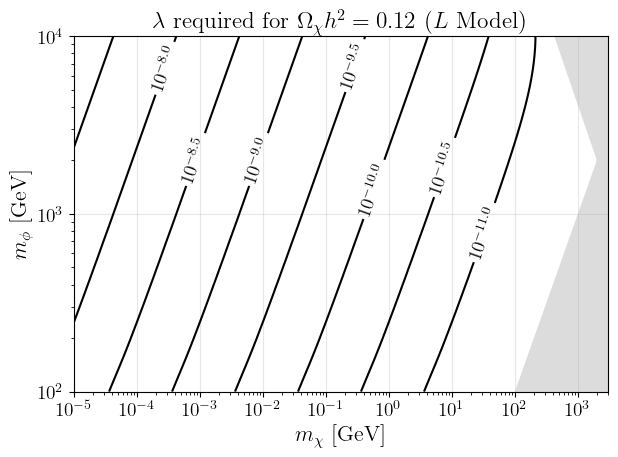

In [19]:
fig3 = figure()

xlim(1e-5, 3e3)
ylim(1e2, 1e4)

xscale("log")
yscale("log")

grid(alpha=0.3)

title(L"$\lambda$ required for $\Omega_\chi h^2 = 0.12$ ($L$ Model)")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")

levels = 10 .^reverse([-6, -6.5, -7, -7.5, -8, -8.5, -9, -9.5, -10, -10.5, -11])
C = contour(mchis, mphis[1:670], lam2[1:670,:], levels=levels, norm="log", colors="k")

formatter(l) = L"10^{ %$(log10(l)) }"

lvs = 10 .^reverse([-6, -6.5, -7, -8, -8.5, -9, -9.5, -10, -10.5, -11])
# lvs = levels

fill_betweenx(mphi_for_bound, mχ_upper, 4e3, color="gainsboro")#, alpha=0.2)

clabel(C, lvs[1:end-3], colors="black", fmt=formatter, use_clabeltext=true, 
        inline=true, inline_spacing=5, fontsize=14)#, manual=((3e-5, 5e3), (3e-4, 4e3),
        # (3e-3, 3e3), (3e-2, 3e3), (3e-1, 3e3), (3e0, 3e3), (3e1, 3e2)))

plotclose()
fig3.savefig(figdir * "LL_lambda_relic.pdf", bbox_inches="tight")
fig3

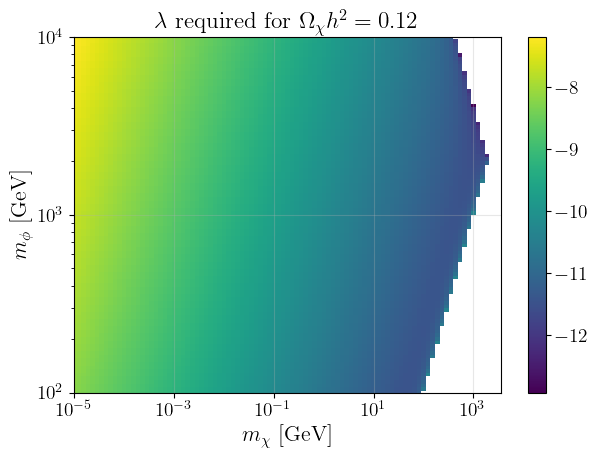

In [17]:
f6 = figure()

xlim(1e-5, 3.6e3)
ylim(1e2, 1e4)

xscale("log")
yscale("log")

grid(alpha=0.3)

title(L"$\lambda$ required for $\Omega_\chi h^2 = 0.12$")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")

# levels = 10 .^reverse([-6, -6.5, -7, -7.5, -8, -8.5, -9, -9.5, -10, -10.5, -11])
C = pcolormesh(mchis, mphis, log10.(lambdas))
colorbar(C)

plotclose()
# f6.savefig("pcolormesh_lambda_relic.pdf")
f6

In [44]:
find_τφm(mφ, mχ) = lifetime_φm(find_λ(mφ, mχ), mφ, mχ)
find_τφms(Mφ, Mχ) = lifetime_φm.(find_λs(Mφ, Mχ), Mφ, Mχ')
;

In [46]:
find_τφm(1e3, 1e-1)*1e9

0.4682359288725152

In [138]:
φ0_lifetimes = lifetime_φ0.(lambdas, mphis, mchis');

In [22]:
gev_to_ns = ustrip(unnatural(u"ns", 1*u"GeV^-1"))

6.582119569509066e-16

In [23]:
# φm_lifetimes = lifetime_φm.(lambdas, mphis, mchis');
φm_lifetimes = gev_to_ns ./ phim_totwidth;

In [73]:
find_λ(1e3,1e-5)

2.045676286985731e-8

In [74]:
function mchi_life(wphi, mphi, yphi_FO)
    I = yχf_I(mphi)
    yχ = 6*I/(2*π^2*mphi^2*utils.h_consts)
    model1 = LFDM(0.0, mphi, 0.0)
    Γ_to_χ = 1/3 * (wphi - Γ_φm_to_φ0eν(model1) - Γ_φm_to_φ0μν(model1))

    return Mstar_s(mphi/25) / (yχ*Γ_to_χ + yphi_FO)
end

function mchi_life(wphi, mphi)
    yphi_FO = sum(find_yφfo(mphi))
    return mchi_life(wphi, mphi, yphi_FO)
end

function mchi_bounds(wphi_low, wphi_up, mphi)
    yphi_FO = sum(find_yφfo(mphi))

    mchi_max = min(Mstar_s(mphi/25)/yphi_FO, mphi)
    mchi_min = 1e-5 # GeV

    model_min = LFDM(find_λ(mphi, 0.999*mchi_max, yphi_FO), mphi, 0.999*mchi_max)
    model_max = LFDM(find_λ(mphi, mchi_min, yphi_FO), mphi, mchi_min)

    wphi_min = Γ_φm_tot(model_min)
    wphi_max = Γ_φm_tot(model_max)
    println("min: $wphi_min, max: $wphi_max")

    if wphi_max <= wphi_low
        return [0.0, 0.0]
    elseif (wphi_max <= wphi_up) && (wphi_min <= wphi_low)
        return [mchi_min, mchi_life(wphi_low, mphi, yphi_FO)]
    elseif (wphi_max <= wphi_up) && (wphi_min <= wphi_up)
        return [mchi_min, mchi_max]
    elseif (wphi_max >= wphi_up) && (wphi_min <= wphi_low)
        return [mchi_life(wphi_up, mphi, yphi_FO), mchi_life(wphi_low, mphi, yphi_FO)]
    elseif (wphi_max >= wphi_up) && (wphi_min <= wphi_up)
        return [mchi_life(wphi_up, mphi, yphi_FO), mchi_max]
    else
        return [0.0, 0.0]
    end
end
;

In [80]:
mχ_prompt = mchi_life.(gev_to_ns/0.03, mphi_for_bound);

In [146]:
writedlm("./data/L_mphi_for_bound.csv", mphi_for_bound)
writedlm("./data/L_mchi_upper.csv", mχ_upper)
writedlm("./data/L_mchi_prompt_boundary.csv", mχ_prompt)
writedlm("./data/L_mphi_hscp.csv", Mphis_hscp)
writedlm("./data/L_mchi_hscp.csv", mchi_hscp)
writedlm("./data/L_mchi_hscp_upper.csv", mchi_hscp_up)
writedlm("./data/L_mphi_for_seR.csv", seR_mphis)
writedlm("./data/L_seR_lower.csv", seR_lo_mχ)
writedlm("./data/L_seR_upper.csv", seR_hi_mχ)
;

In [83]:
Mphis_hscp = 10 .^ range(2, log10(520), 50)
yphi_fo_hscp = [sum(find_yφfo(mf)) for mf in Mphis_hscp]
mchi_hscp = mchi_life.(gev_to_ns/1.0, Mphis_hscp, yphi_fo_hscp)
mchi_hscp_up = mχ_upper_bound.(Mphis_hscp, yphi_fo_hscp)
;

In [86]:
seR_dir = "./data/selectron_bounds/"

se_lo_data = readdlm(seR_dir * "seR_bounds_lower.csv", ',')
se_hi_data = readdlm(seR_dir * "seR_bounds_upper.csv", ',')

se_lo_func = linear_interpolation(se_lo_data[:,1], se_lo_data[:,2], extrapolation_bc=Line())
se_hi_func = linear_interpolation(se_hi_data[:,1], se_hi_data[:,2], extrapolation_bc=Line())

seR_mphis = 10 .^ range(2.0, log10(584), 100)

seR_bounds = mchi_bounds.(gev_to_ns ./ se_hi_func.(seR_mphis), 
                         gev_to_ns ./ se_lo_func.(seR_mphis),
                         seR_mphis)
;

min: 3.538184540237053e-17, max: 2.4947680753709717e-16
min: 4.023150315256117e-17, max: 2.627012319191932e-16
min: 4.549140809059253e-17, max: 2.766719530717636e-16
min: 5.116781078463793e-17, max: 2.914091784986168e-16
min: 5.72650248933e-17, max: 3.0693176642211394e-16
min: 6.378549546653076e-17, max: 3.2325734488051453e-16
min: 7.072986999459516e-17, max: 3.40406003423467e-16
min: 7.809708723901867e-17, max: 3.583946016400294e-16
min: 8.588447202129555e-17, max: 3.772334768599321e-16
min: 9.408780479685755e-17, max: 3.969364677160285e-16
min: 1.0270156679618815e-16, max: 4.175168852540456e-16
min: 1.117188057664448e-16, max: 4.389874426463662e-16
min: 1.2113132645695247e-16, max: 4.613595705742734e-16
min: 1.3093004139852637e-16, max: 4.845903566250064e-16
min: 1.41104714175357e-16, max: 5.087428926940793e-16
min: 1.5164428791440974e-16, max: 5.338290838035263e-16
min: 1.625368880664603e-16, max: 5.598610705505952e-16
min: 1.737699442046441e-16, max: 5.86851344936784e-16
min: 1.853

In [90]:
seR_lo_mχ = [s[1] for s in seR_bounds]
seR_hi_mχ = [s[2] for s in seR_bounds]
;

In [ ]:
mχ_prompt = readdlm("./data/L_mchi_prompt_boundary.csv")[:]
Mphis_hscp = readdlm("./data/L_mphi_hscp.csv")[:]
mchi_hscp = readdlm("./data/L_mchi_hscp.csv")[:]
mchi_hscp_up = readdlm("./data/L_mchi_hscp_upper.csv")[:]
seR_mphis = readdlm("./data/L_mphi_for_seR.csv")[:]
seR_lo_mχ = readdlm("./data/L_seR_lower.csv")[:]
seR_hi_mχ = readdlm("./data/L_seR_upper.csv")[:]
;

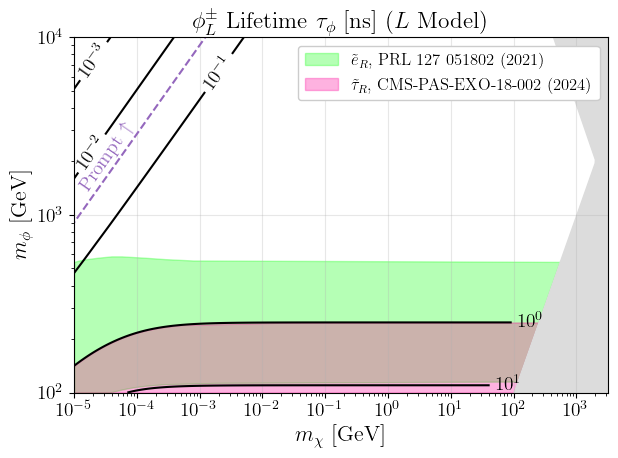

In [145]:
fig4 = figure()

xlim(1e-5, 3.2e3)
ylim(1e2, 1e4)

xscale("log")
yscale("log")

levels = 10.0 .^(-6:8)
C = contour(mchis, mphis, φm_lifetimes, levels=levels, norm="log", colors="black")

formatter(l) = L"10^{ %$(Int(log10(l))) }"

clabel(C, levels, colors="black", fmt=formatter, use_clabeltext=true, 
        inline=true)

hscpi = (mchi_hscp .> 0.0)
fill_betweenx(seR_mphis, seR_lo_mχ, seR_hi_mχ, color="xkcd:neon green", alpha=0.3, label=L"$\tilde{e}_R$, PRL 127 051802 (2021)")
fill_betweenx(Mphis_hscp[hscpi], mchi_hscp[hscpi], mchi_hscp_up[hscpi], color="xkcd:neon pink", alpha=0.3, label=L"$\tilde{\tau}_R$, CMS-PAS-EXO-18-002 (2024)")
fill_betweenx(mphi_for_bound, mχ_upper, 6e3, color="gainsboro")

plot(mχ_prompt, mphi_for_bound, c="tab:purple", linestyle="dashed")

text(1.1e-5, 1.35e3, L"Prompt $\uparrow$", rotation=55.3, c="tab:purple")
grid(alpha=0.3)

title(L"$\phi_L^{\pm}$ Lifetime $\tau_\phi$ [ns] ($L$ Model)")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")

legend(fontsize=12, framealpha=1, loc="upper right")

plotclose()
fig4.savefig(figdir * "L_phim_lifetime.pdf")
fig4

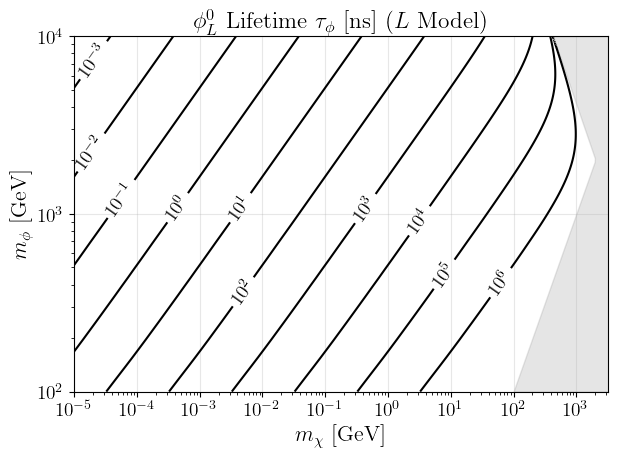

In [141]:
fig5 = figure()

xlim(1e-5, 3.2e3)
ylim(1e2, 1e4)

xscale("log")
yscale("log")

levels = 10.0 .^(-6:6)

C = contour(mchis, mphis, φ0_lifetimes .* 1e9, levels=levels, norm="log", colors="black")

formatter(l) = L"10^{ %$(Int(log10(l))) }"

clabel(C, levels, colors="black", fmt=formatter, use_clabeltext=true, 
        inline=true)

fill_betweenx(mphi_for_bound, mχ_upper, 6e3, color="grey", alpha=0.2)

# plot(mχ_prompt, Mphis_life)

grid(alpha=0.3)

title(L"$\phi_L^{0}$ Lifetime $\tau_\phi$ [ns] ($L$ Model)")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")

plotclose()
fig5.savefig(figdir * "L_phi0_lifetime.pdf")
fig5